In [5]:
import numpy as np
from dipy.io.image import save_nifti, load_nifti
import torchio as tio
import torch
import torchio.transforms as transforms
import matplotlib.pyplot as plt

from monai.transforms import NormalizeIntensityd

def show_img(img):
    img = np.squeeze(img)
    plt.figure(dpi=150)
    plt.imshow(img, cmap='gray')
    # plt.colorbar()
    cbar = plt.colorbar(shrink=0.5)
    plt.xticks([])
    plt.yticks([])
    plt.show()

### 1.Load data & Domain permutation
#### Adjusting x, y, and z orientations and cropping unnecessary parts of the subject (background, below the neck).

Loaded data of size: (300, 320, 208, 1)
<class 'numpy.memmap'>
Permuted data of size: (300, 208, 320, 1)
Truncated data of size: (200, 200, 180)


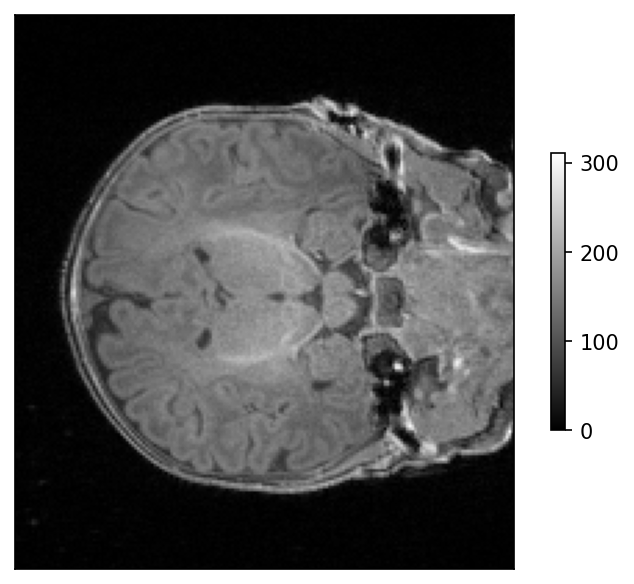

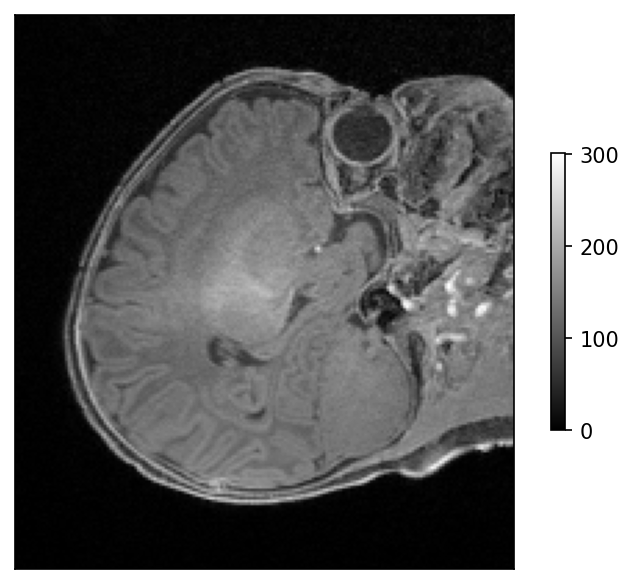

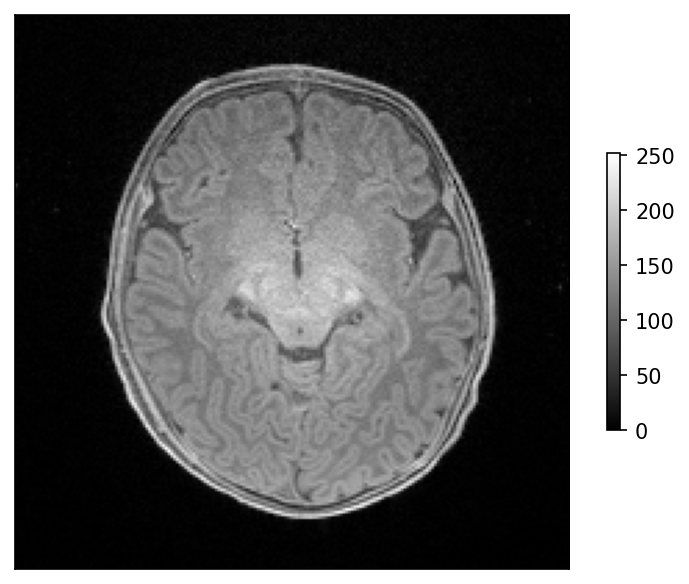

In [6]:
dataroot= 'mprage_BCP_G.nii'
raw_data, _ = load_nifti(dataroot)
print('Loaded data of size:', raw_data.shape)
print(type(raw_data))

perm_raw_data = np.transpose(raw_data, (0,2,1,3))
print('Permuted data of size:', perm_raw_data.shape)

perm_data = perm_raw_data[65:265,0:200,50:230,:].squeeze()
print('Truncated data of size:', perm_data.shape)

xx = 100
yy = 80
zz = 100
show_img(perm_data[xx,:,:].squeeze())
show_img(perm_data[:,yy,:].squeeze())
show_img(perm_data[:,:,zz].squeeze())

### 2.MONAI normalization & Min, Max, Mean, Std
#### Use the MONAI NormalizeIntensityd function for normalization and check the results for min, max, mean, and standard deviation.
#### The purpose of this normalization is to bring different variables onto a common scale, making them directly comparable.
####   a) Calculate the mean (μ) and standard deviation (σ) of the dataset.
####   b) Subtract the mean from each data point. This centers the data around zero, ensuring that the new mean becomes zero.
####   c) Divide each data point by the standard deviation. This scales the data, making the new standard deviation equal to one.

Max: 577
Min: 0
Mean: 43.24270986111111
Std: 61.21187985510285
Max: 8.719831
Min: -0.7064431
Mean: 4.937066e-08
Std: 1.0000002


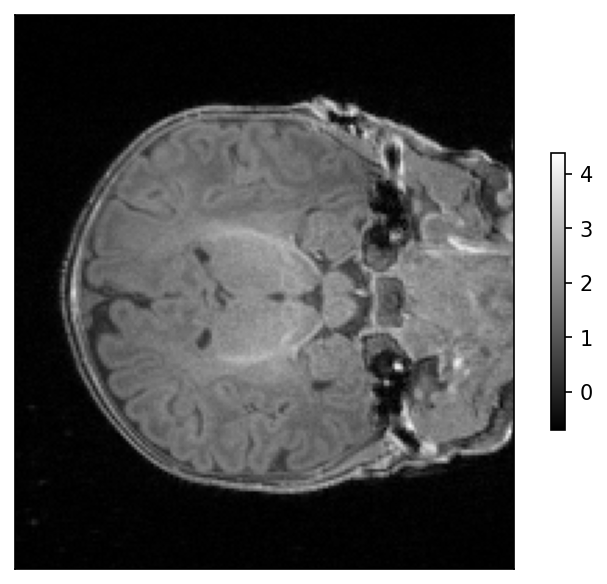

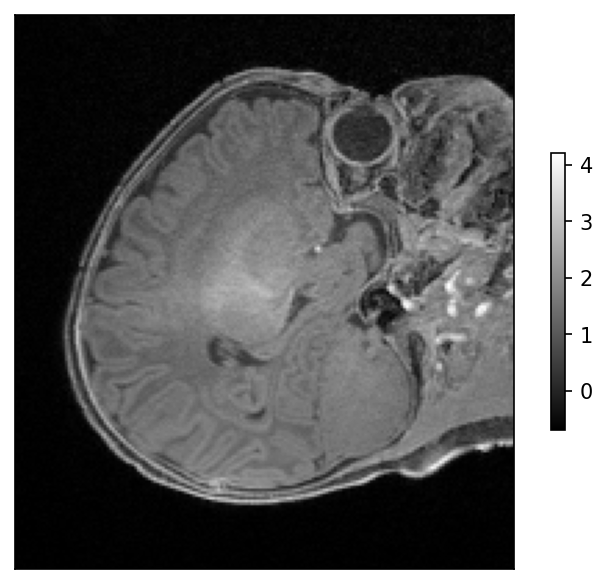

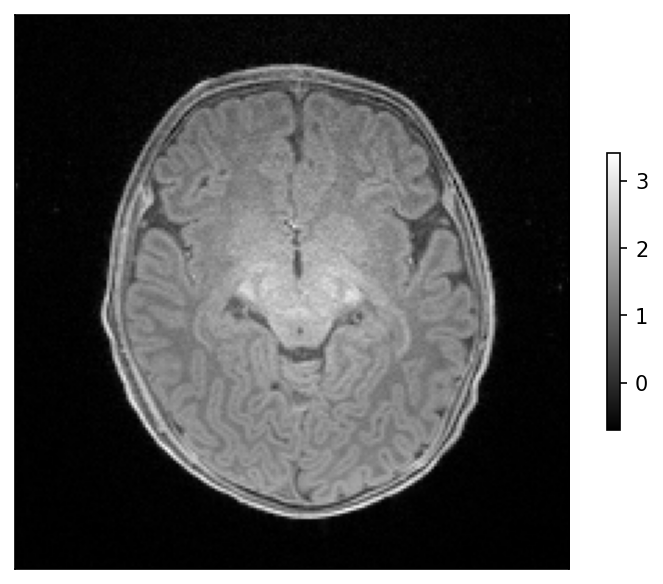

In [7]:
max_value = np.max(perm_data)
print("Max:", max_value)

min_value = np.min(perm_data)
print("Min:", min_value)

mean_value = np.mean(perm_data)
print("Mean:", mean_value)

std_value = np.std(perm_data)
print("Std:", std_value)

normalize = NormalizeIntensityd(keys=["image"], subtrahend=mean_value, divisor=std_value)
data = {
    "image": perm_data
}
normalized_data = normalize(data)
tmp = normalized_data["image"]

max_value = np.max(tmp)
print("Max:", max_value)

min_value = np.min(tmp)
print("Min:", min_value)

mean_value = np.mean(tmp)
print("Mean:", mean_value)

std_value = np.std(tmp)
print("Std:", std_value)

xx = 100
yy = 80
zz = 100
show_img(tmp[xx,:,:].squeeze())
show_img(tmp[:,yy,:].squeeze())
show_img(tmp[:,:,zz].squeeze())

### 3.Generating random motion
#### a) degrees: The rotation range in degrees of the simulated movements
#### b) translation: The translation in mm of the simulated movements
#### c) num_transforms: Number of simulated movements. Larger values generate more distorted images

In [33]:
# Define the RandomMotion transform
random_motion = tio.RandomMotion(
    degrees=15,  # Maximum rotation angle in degrees
    translation=15,  # Maximum translation in mm
    num_transforms=2  # Number of motion transformations to apply
)

tmp2 = np.expand_dims(tmp, axis=0)
motion_data = random_motion(tmp2).squeeze()

print(motion_data.shape)

m_max_value = np.max(motion_data)
print("N_Max:", m_max_value)

m_min_value = np.min(motion_data)
print("N_Min:", m_min_value)

m_mean_value = np.mean(motion_data)
print("N_Mean:", m_mean_value)

m_std_value = np.std(motion_data)
print("N_Std:", m_std_value)

(200, 200, 180)
N_Max: 6.51193
N_Min: -1.876056
N_Mean: -4.3470596e-08
N_Std: 0.99147683


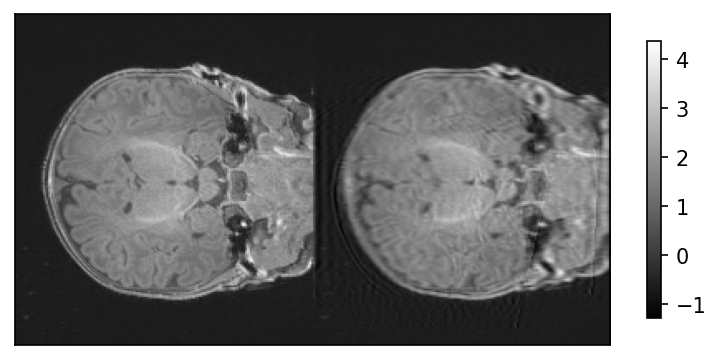

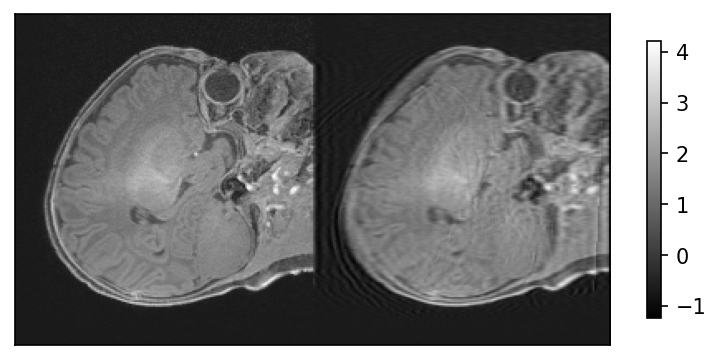

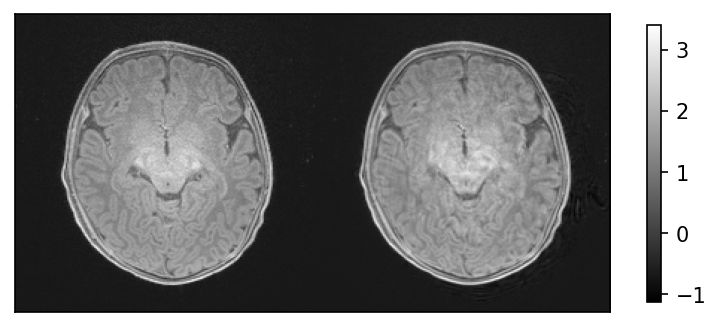

In [34]:
xx = 100
yy = 80
zz = 100
show_img(np.concatenate((tmp[xx,:,:].squeeze(), motion_data[xx,:,:].squeeze()),1))
show_img(np.concatenate((tmp[:,yy,:].squeeze(), motion_data[:,yy,:].squeeze()),1))
show_img(np.concatenate((tmp[:,:,zz].squeeze(), motion_data[:,:,zz].squeeze()),1))

### 4. Save the results

In [35]:
np.save('BCP_G_clean.npy', tmp.squeeze())

In [36]:
np.save('BCP_G_motion.npy', motion_data.squeeze())

### 5.Load the results

In [37]:
import numpy as np
raw_data = np.load('D:/WACV/2023.05.26_Preprocessing_NA/2. RandomGhosting/BCP_G_clean.npy')
print('Loaded data of size:', raw_data.shape)

motion_data = np.load('D:/WACV/2023.05.26_Preprocessing_NA/2. RandomGhosting/BCP_G_motion.npy')
print('Loaded data of size:', motion_data.shape)

Loaded data of size: (200, 200, 180)
Loaded data of size: (200, 200, 180)


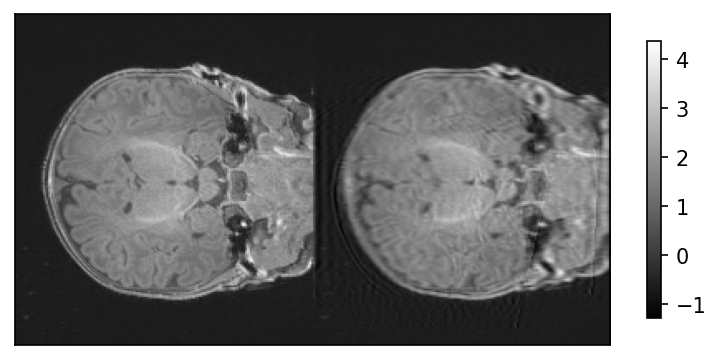

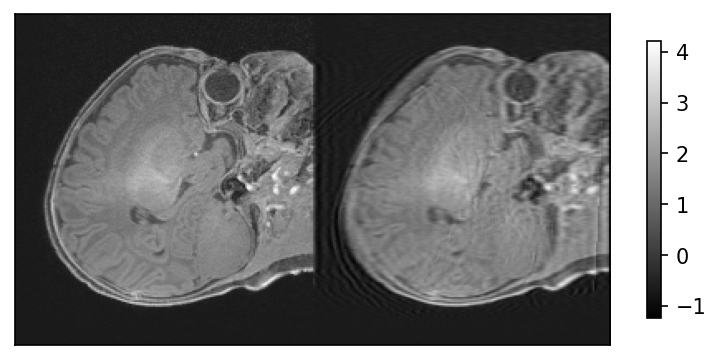

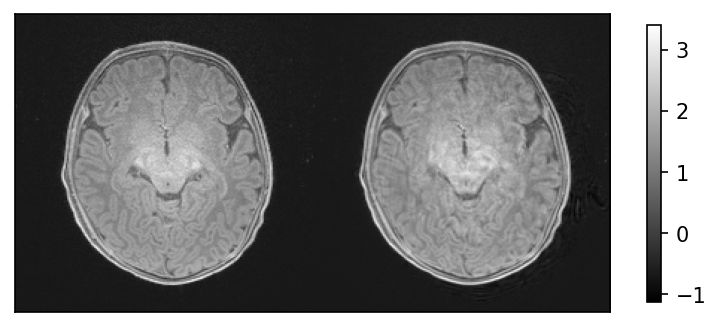

In [38]:
xx = 100
yy = 80
zz = 100
show_img(np.concatenate((raw_data[xx,:,:].squeeze(), motion_data[xx,:,:].squeeze()),1))
show_img(np.concatenate((raw_data[:,yy,:].squeeze(), motion_data[:,yy,:].squeeze()),1))
show_img(np.concatenate((raw_data[:,:,zz].squeeze(), motion_data[:,:,zz].squeeze()),1))

### 6.Caculate nRMSE
#### a) Calculate Mean Squared Error (MSE)
#### b) Calculate Root Mean Squared Error (RMSE)
#### c) Calculate Normalized Root Mean Squared Error (nRMSE)

In [39]:
def nrmse(predicted, actual):
    mse = np.mean((predicted - actual) ** 2)  # 평균 제곱 오차 계산
    rmse = np.sqrt(mse)  # 평균 제곱근 오차 계산
    range_val = np.max(actual) - np.min(actual)  # 실제값의 범위 계산
    nrmse_val = rmse / range_val  # 정규화된 평균 제곱근 오차 계산
    return nrmse_val

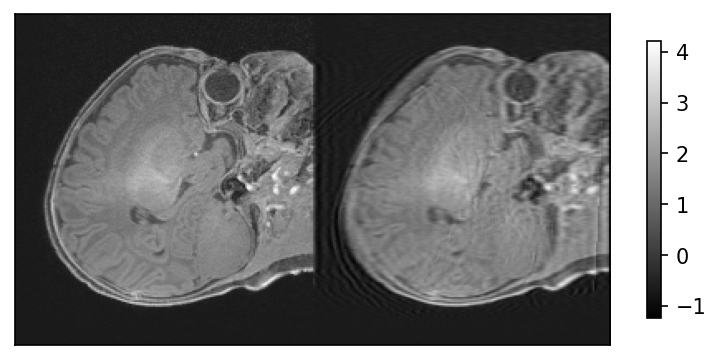

nRMSE= 4.51 %


In [41]:
yy = 80
show_img(np.concatenate((raw_data[:,yy,:].squeeze(), motion_data[:,yy,:].squeeze()),1))

print('nRMSE=', round(nrmse(motion_data[:,yy,:].squeeze(), raw_data[:,yy,:].squeeze())*100, 2), '%')